# **Modelo de Predicción de Primas de Seguros**
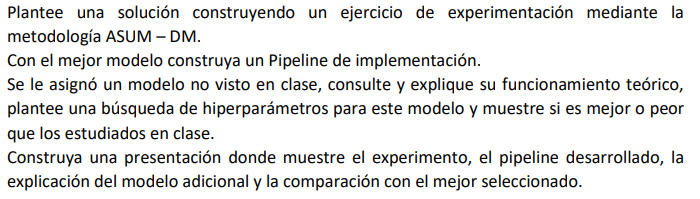

-  Seriada: Un arreglo como vector, donde se tiene el valor de la y definida con datos como serie de tiempo. El problema cambia, ml siempre deben contar con variables x que definan a la y. Aqui no tenemos esas variables, es por eso que tendremos que crear las x.
    Va a depender de cómo tenga los datos 
-  También genera el pipeline del modelo, en clasificación llegamos hasta que el modelo está ajustado, ahora vamos a ver escenarios que nos permitan llevar ese modelo validado a funcionamiento con las primeras étapas de mlops. 
- Porcentaje del error medio absoluto (MAPE)
    - qué tanto se está separando el valor de sus predicciones al valor real, muchas veces lo multiplican por 100.
    - Buscamos que tienda a 0, ya que es error 
    - Si se quiere mirar probabilidad 1- MAPE, osea predecir correctamente 


# **1. Entendimiento del Problema**

Como parte del **equipo de tarifación de una aseguradora**, se requiere construir un modelo predictivo que pueda pronosticar el valor de la prima de un asegurado con una precisión específica de MAPE menor o igual al
15%.


# **2. Enfoque Analítico**

Construir un modelo de regresion para predecir el valor de la prima de un asegurado con un MAPE menor al 15%. (Probabilidad superior al 85%) para la predicción del valor de las primas de seguros.

# **3. Requerimiento de Datos**

- Se requieren datos de los asegurados (Edad, genero, estado civil, hijos, tipo de trabajo, nivel educativo, ingresos anuales, tipo de residencia, valor de la prima)
- Datos historicos de primas pagadas por los asegurados

# **4. Recolección de Datos**
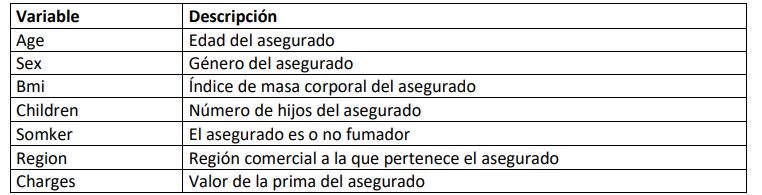

In [182]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('datos_caso_3.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# **5. Entendimiento de los Datos** 

- Conocer nuestra variable y (escencial ya que es lo que le va a decir al modelo los datos que quiero que se aprenda )
- identificar datos nulos
- analisis multivariado y univariado

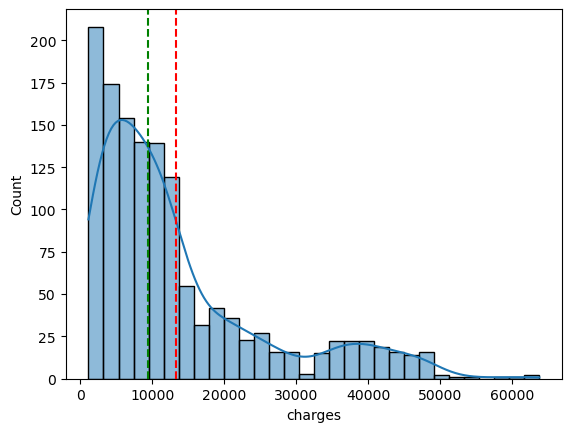

In [185]:
#la media y la mediana del conjunto con la variable x como changes y 
import matplotlib.pyplot as plt
import seaborn as sb

sb.histplot(data = data, x = 'charges', kde = True)
plt.axvline(x = data.charges.mean(), color = 'red', linestyle = 'dashed') 
plt.axvline(x = data.charges.median(), color = 'green', linestyle = 'dashed')
plt.show()
#áreas donla los charges son menores al 15 % y mayor al 15%
#La mediana y la media son cercanas, ahí hay una mayor frecuencia.
#No es normal, es muy dificil que siempre sea normal 


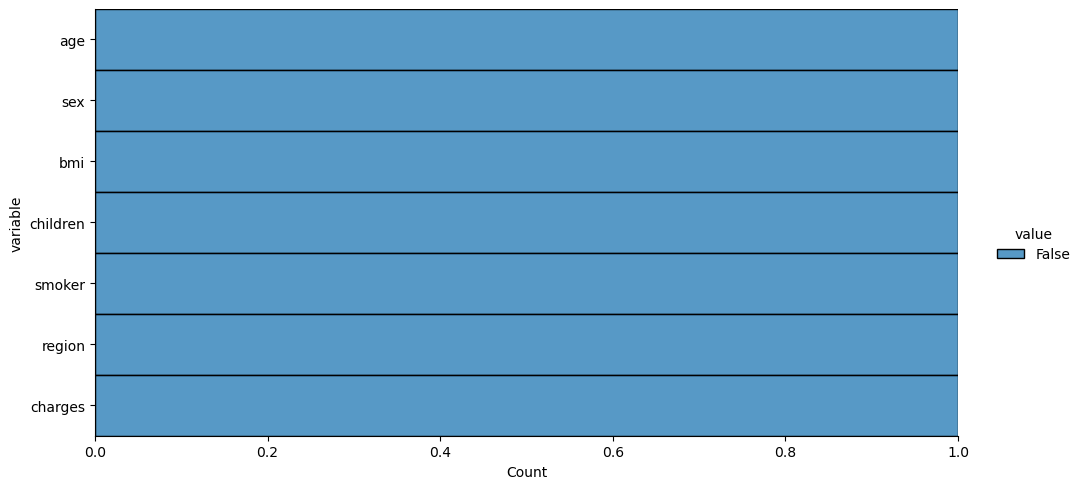

In [186]:
#no hay datos nulos 

data.isnull().melt().pipe(lambda df: sb.displot(data = df, y = 'variable', hue = 'value', multiple = 'fill', aspect=2))
plt.show()

## Exploración univariada de los datos 

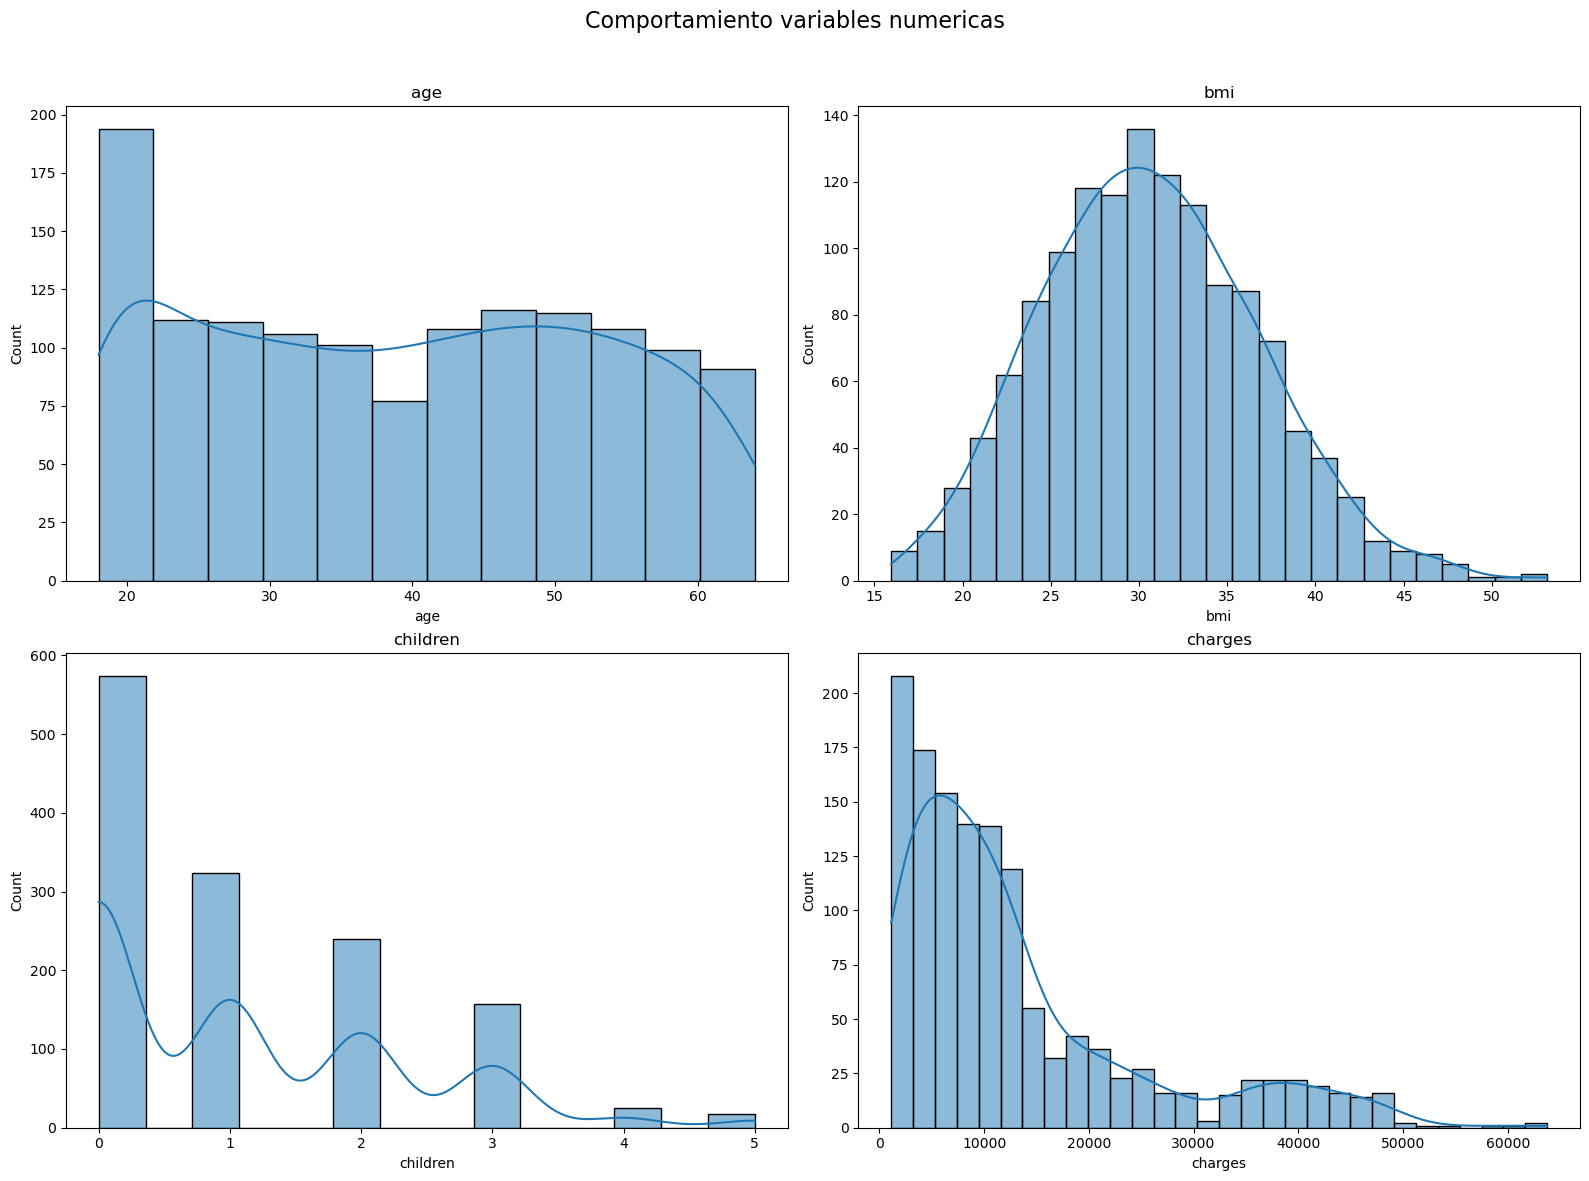

In [187]:
#Histograma de frecuencia para las variables numericas 
fig, ax = plt.subplots(2,2, figsize = (16,12))
ax = ax.flat 
num_cols = data.select_dtypes(include = ['int64', 'float64']).columns
for i, col in enumerate(num_cols):
    sb.histplot(data = data, 
                x = col, 
                kde = True, 
                ax = ax[i])
    ax[i].set_title(col)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Comportamiento variables numericas', fontsize = 16)
plt.show()


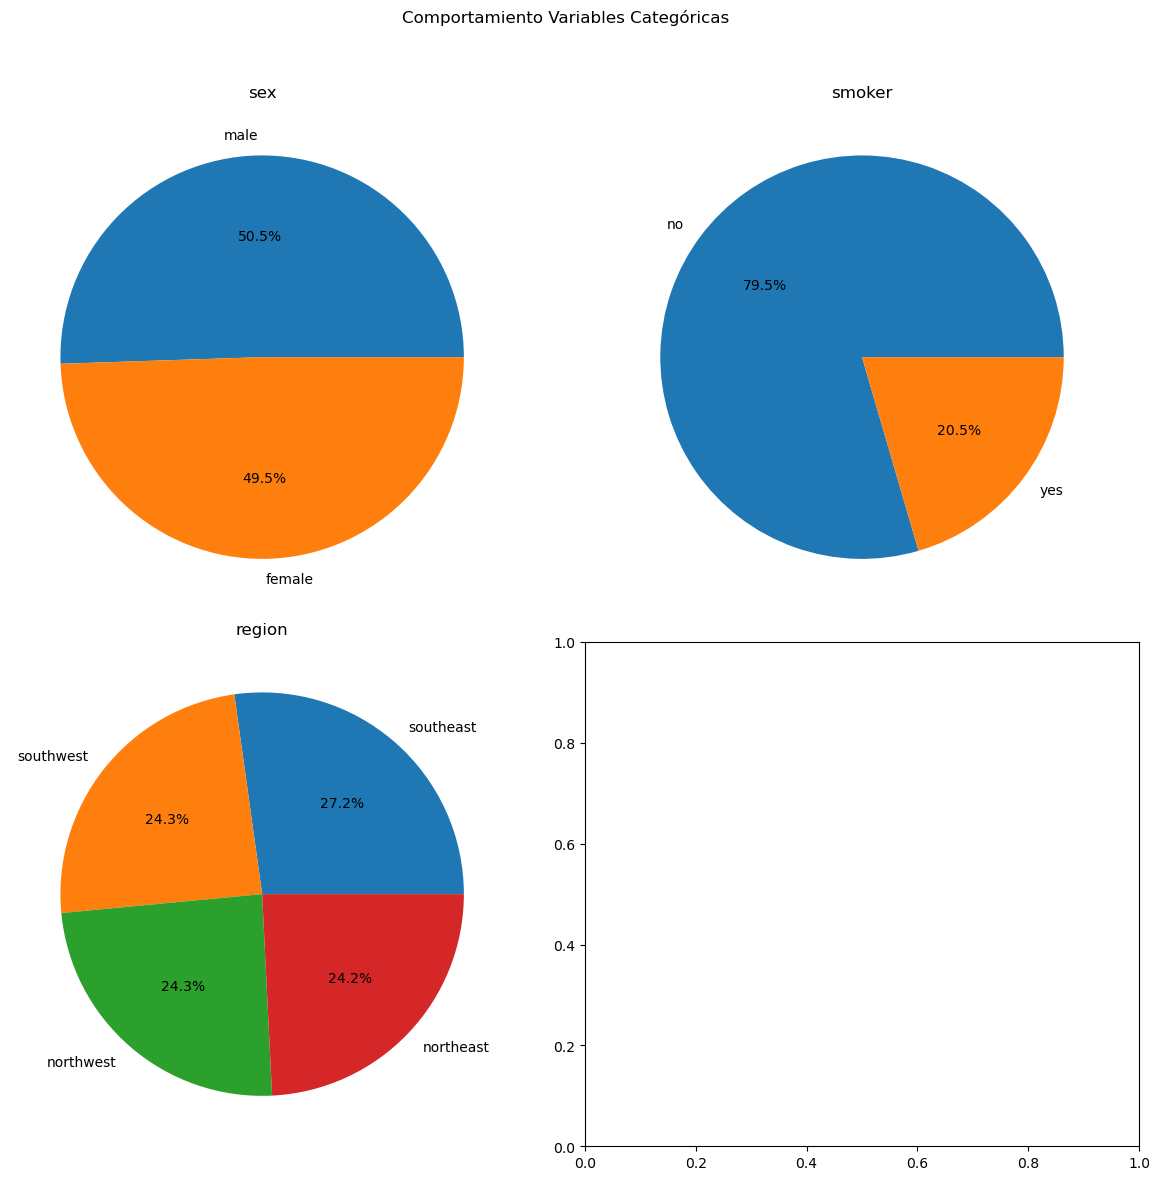

In [188]:
#graficos de torta para  las variables categoricas 
fig, ax = plt.subplots(2, 2, figsize = (12, 12))
ax = ax.flat
cat_col = data.select_dtypes(include = ['object']).columns
for i, col in enumerate(cat_col):
    ax[i].pie(x = data[col].value_counts(), labels = data[col].value_counts().index, autopct = '%0.1f%%')
    ax[i].set_title(col)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.suptitle("Comportamiento Variables Categóricas")
plt.show()

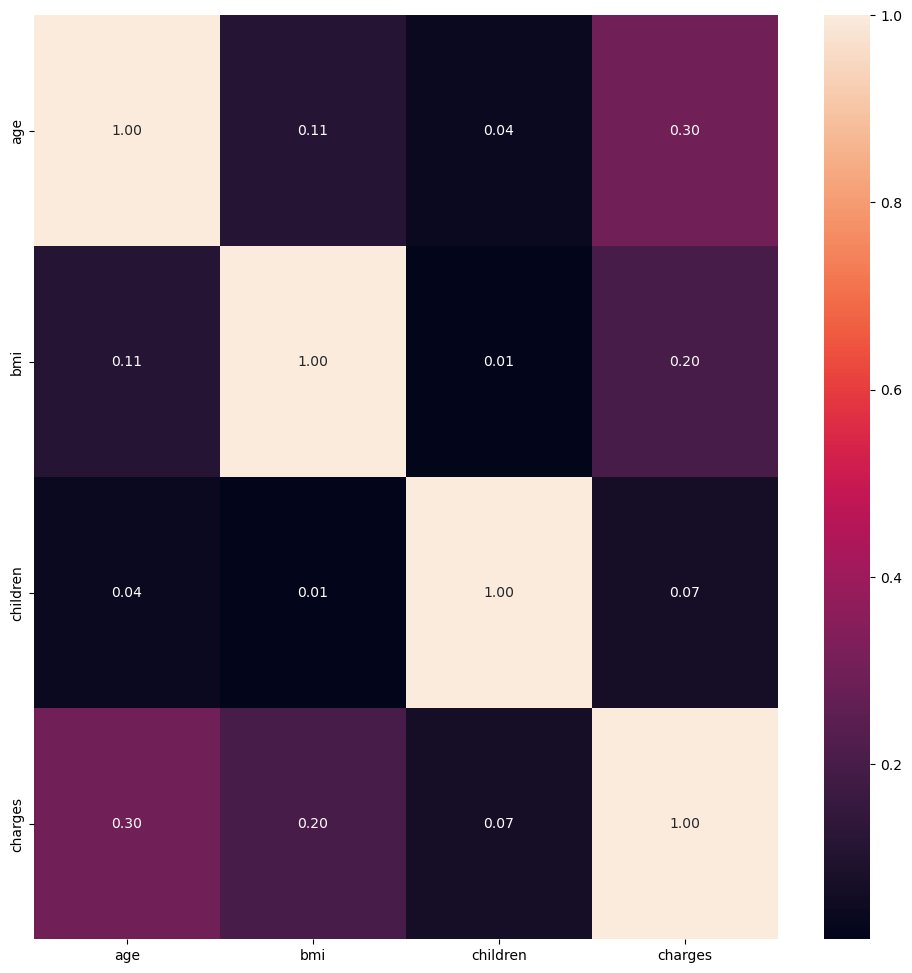

In [190]:
#correlacion
plt.figure(figsize = (12, 12))
sb.heatmap(data.corr(numeric_only=True), annot = True, fmt='.2f')
plt.show()

- Todos los datos del caso 3 están muy bien, no se encontró necesario hacer tratamiento de datos 

# **6. Preparación de los Datos**

- Eliminar variables que no son significativas
- Completar variables que cuentan con datos nulos
- Transformar los datos para que sean usables por el modelo


In [191]:

import sklearn
from sklearn.tree import DecisionTreeRegressor 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline



In [192]:
num_col = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_col = data.select_dtypes(include=['object']).columns.tolist()

num_transformer = Pipeline(steps = [('scaler', MinMaxScaler())])
cat_transformer = Pipeline(steps = [('encoder', OneHotEncoder())])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_transformer, num_col),
    ('cat', cat_transformer, cat_col)
  ],
  remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['age', 'bmi', 'children', 'charges']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['sex', 'smoker', 'region'])])

In [193]:
data_pre = preprocessor.fit_transform(data)

cod_cat = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_col)
labels = np.concatenate([num_col, cod_cat])

data_pro = pd.DataFrame(data_pre, columns=labels)
data_pro

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,0.403820,0.6,0.151299,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,0.000000,0.429379,0.0,0.017305,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,0.000000,0.562012,0.0,0.008108,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,0.065217,0.264730,0.0,0.014144,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Separación de la variable X y Y

In [194]:
X = data_pro.drop('charges', axis = 1)
y = data_pro[['charges']]

El tamaño del conjunto de entrenamiento es: (401, 11) (401, 1)
El tamaño del conjunto de prueba es: (937, 11) (937, 1)


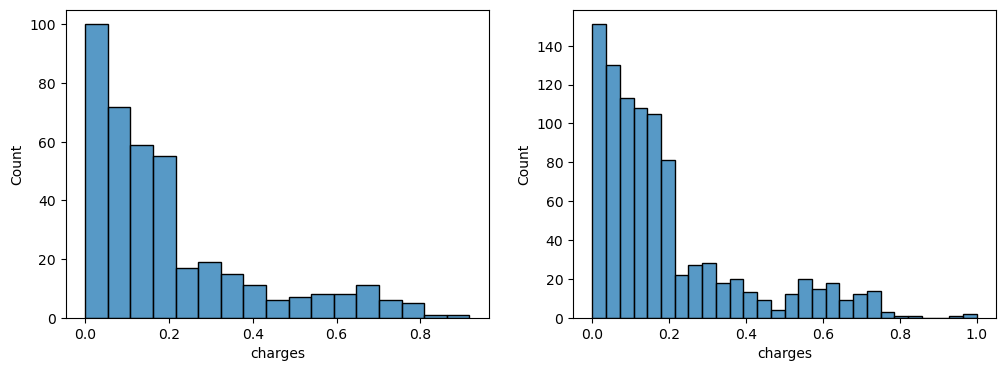

In [195]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=123)

print(f'El tamaño del conjunto de entrenamiento es: {X_train.shape} {y_train.shape}\nEl tamaño del conjunto de prueba es: {X_test.shape} {y_test.shape}')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sb.histplot(data= y_train, x='charges', ax=ax[0])
sb.histplot(data= y_test, x='charges', ax=ax[1])
plt.show()

# **7. Modelado**

- Regresion Lineal
- K Vecinos Mas Cercanos
- Maquina de Soporte Vectorial
- Arboles de Decision
- Random Forest
- AdaBoost
- Gradient Boosting
- Perceptron Multicapa
- Hubber Regressor

# **8. Validación**
- Ajuste cuadratico
- Raiz del error cuadratico medio
- Error absoluto medio
- Porcentaje de error medio absoluto (MAPE)


In [196]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [197]:
def predecir_y_desescalar(modelo, X_train, X_test, y_train, y_test, y_total):
    pred_train = modelo.predict(X_train)
    pred_test = modelo.predict(X_test)
    y_min, y_max = np.min(y_total), np.max(y_total)
    pred_train_des = pred_train * (y_max - y_min) + y_min
    pred_test_des = pred_test * (y_max - y_min) + y_min
    y_train_des = y_train * (y_max - y_min) + y_min
    y_test_des = y_test * (y_max - y_min) + y_min
    return pred_train_des, pred_test_des, y_train_des, y_test_des

In [198]:
modelo_gradient_boosting_regressor = GradientBoostingRegressor()

param_grid = {
  'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
  'loss': ['squared_error', 'absolute_error'],
  'criterion': ['friedman_mse', 'squared_error'],
}

modelo_gradient_boosting_regressor_final = None
mape_test_gradient_boosting_regressor = 1
intento = 1

print("🔍 BÚSQUEDA DEL MEJOR MODELO GRADIENT BOOSTING")
print("=" * 60)
print("Objetivo: Lograr MAPE ≤ 15% en conjunto de test")
print("=" * 60)

while True:
  print(f"\n INTENTO {intento}")
  print("-" * 40)
  
  X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.7)

  reg_modelo_gradient_boosting_regressor = GridSearchCV(estimator=modelo_gradient_boosting_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error')
  reg_modelo_gradient_boosting_regressor.fit(X_train_2, y_train_2)

  validation = pd.concat(
    [
      pd.DataFrame(reg_modelo_gradient_boosting_regressor.cv_results_['params']),
      pd.DataFrame(reg_modelo_gradient_boosting_regressor.cv_results_['mean_test_score'], columns=['MAPE'])
    ],
    axis=1
  )
  validation.sort_values('MAPE', ascending=False)

  modelo_gradient_boosting_regressor_final = reg_modelo_gradient_boosting_regressor.best_estimator_
  
  print(f" Mejores parámetros: {reg_modelo_gradient_boosting_regressor.best_params_}")

  pred_train_gradient_boosting_regressor, pred_test_gradient_boosting_regressor, y_train_des, y_test_des = predecir_y_desescalar(modelo_gradient_boosting_regressor_final, X_train, X_test, y_train, y_test, y)

  mape_train_gradient_boosting_regressor = mean_absolute_percentage_error(y_train_des, pred_train_gradient_boosting_regressor)
  mape_test_gradient_boosting_regressor = mean_absolute_percentage_error(y_test_des, pred_test_gradient_boosting_regressor)
  
  print(f" RESULTADOS:")
  print(f"   MAPE Train: {mape_train_gradient_boosting_regressor:.4f} ({mape_train_gradient_boosting_regressor*100:.2f}%)")
  print(f"   MAPE Test:  {mape_test_gradient_boosting_regressor:.4f} ({mape_test_gradient_boosting_regressor*100:.2f}%)")
  
  if mape_test_gradient_boosting_regressor >= 0.15:
    print(f"    MAPE Test > 15% - Continuando búsqueda...")
  else:
    print(f"   ¡OBJETIVO ALCANZADO! MAPE Test ≤ 15%")
    print(f"   Modelo final encontrado en intento {intento}")
    break 

  intento += 1
  
  # Agregar límite de seguridad para evitar bucle infinito
  if intento > 50:
    print(f"\n⚠  Se alcanzó el límite de 50 intentos. Deteniendo búsqueda.")
    print(f"   Mejor resultado obtenido: MAPE Test = {mape_test_gradient_boosting_regressor*100:.2f}%")
    break

print("\n" + "=" * 60)
print(" BÚSQUEDA COMPLETADA")
print("=" * 60)

modelo_gradient_boosting_regressor_final

🔍 BÚSQUEDA DEL MEJOR MODELO GRADIENT BOOSTING
Objetivo: Lograr MAPE ≤ 15% en conjunto de test

 INTENTO 1
----------------------------------------
 Mejores parámetros: {'criterion': 'friedman_mse', 'loss': 'absolute_error', 'n_estimators': 400}
 RESULTADOS:
   MAPE Train: 65542121402.6131 (6554212140261.31%)
   MAPE Test:  0.3687 (36.87%)
    MAPE Test > 15% - Continuando búsqueda...

 INTENTO 2
----------------------------------------
 Mejores parámetros: {'criterion': 'squared_error', 'loss': 'absolute_error', 'n_estimators': 900}
 RESULTADOS:
   MAPE Train: 25195317193.5074 (2519531719350.74%)
   MAPE Test:  0.1456 (14.56%)
   ¡OBJETIVO ALCANZADO! MAPE Test ≤ 15%
   Modelo final encontrado en intento 2

 BÚSQUEDA COMPLETADA


GradientBoostingRegressor(criterion='squared_error', loss='absolute_error',
                          n_estimators=900)

In [199]:
modelo_gradient_boosting_regressor_final

GradientBoostingRegressor(criterion='squared_error', loss='absolute_error',
                          n_estimators=900)

## **Regresion Lineal**

In [200]:
modelo_1 = LinearRegression()
modelo_1.fit(X_train, y_train)

LinearRegression()

In [201]:
modelo_1.coef_

array([[ 0.18152455,  0.24378779,  0.02183742,  0.00323495, -0.00323495,
        -0.18477517,  0.18477517,  0.00822192,  0.00804215, -0.01054098,
        -0.00572309]])

In [202]:
modelo_1.intercept_

array([0.11733013])

- Este modelo se desescala porque el MAPE se calcula con los datos originales, no con los escalados. Esto debido a que el MAPE puede ser infinito si no se desescala.

Las metricas de desempeño en entrenamiento para la regresion lineal son:
R2: 0.7425
RMSE: 0.1001
MAE: 0.0711
MAPE: 378147569471.1707


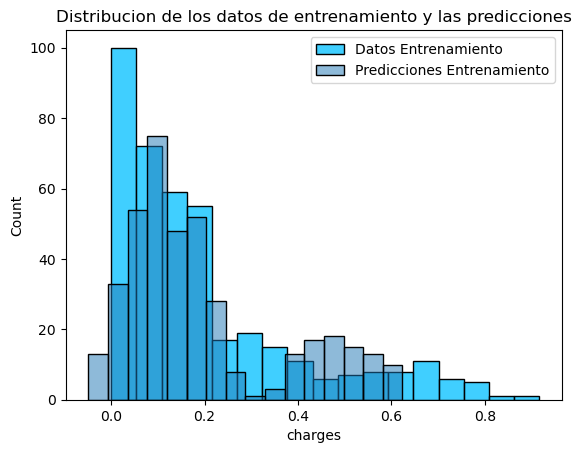

In [203]:
#Predicciones
pred_train_1 = modelo_1.predict(X_train)
pred_test_1 = modelo_1.predict(X_test)


#Desescalado de las predicciones y los valores reales
pred_train_des_1 = pred_train_1 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_1 = pred_test_1 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_1 = r2_score(y_train_des, pred_train_des_1)
rmse_train_1 = root_mean_squared_error(y_train_des, pred_train_des_1)
mae_train_1 = mean_absolute_error(y_train_des, pred_train_des_1)
mape_train_1 = mean_absolute_percentage_error(y_train_des, pred_train_des_1)
print(f'Las metricas de desempeño en entrenamiento para la regresion lineal son:\nR2: {r2_train_1:.4f}\nRMSE: {rmse_train_1:.4f}\nMAE: {mae_train_1:.4f}\nMAPE: {mape_train_1:.4f}')

#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_1, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()

In [204]:
y_test_des 


,charges
650,0.138535
319,0.056597
314,0.538193
150,0.063902
336,0.175913
...,...
24,0.081120
29,0.600000
838,0.084286
199,0.219951


Las metricas de desempe;o en prueba para la regresion lineal son:
R2: 0.7511
RMSE: 0.0955
MAE: 0.0682
MAPE: 1.7777


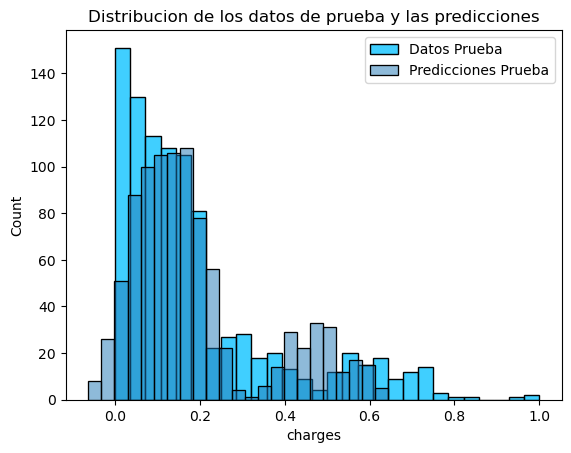

In [205]:
r2_test_1 = r2_score(y_test_des, pred_test_des_1)
rmse_test_1 = root_mean_squared_error(y_test_des, pred_test_des_1)
mae_test_1 = mean_absolute_error(y_test_des, pred_test_des_1)
mape_test_1 = mean_absolute_percentage_error(y_test_des, pred_test_des_1)
print(f'Las metricas de desempe;o en prueba para la regresion lineal son:\nR2: {r2_test_1:.4f}\nRMSE: {rmse_test_1:.4f}\nMAE: {mae_test_1:.4f}\nMAPE: {mape_test_1:.4f}')

#Visualizacion de las predicciones

sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_1, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()

- El mape no es buen indicador porque se tiene un cero en y da valores muy grandes.
- R2 la probabilidad de que el modelo se ajuste es de 75.1%.

## **K vecinos más cercanos**

In [206]:

modelo_2 = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 100, 1000],
    'p': [1, 2],  # 1 para Manhattan, 2 para Euclidean
}

reg_2 = GridSearchCV(estimator=modelo_2,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_mean_absolute_percentage_error',)
reg_2.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_2.cv_results_['params']), 
                        pd.DataFrame(reg_2.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)

,n_neighbors,p,MAPE
0,2,1,-2.272675e+09
1,2,2,-2.272675e+09
2,3,1,-5.346691e+10
6,5,1,-5.482447e+10
4,4,1,-6.729095e+10
8,6,1,-9.916768e+10
3,3,2,-1.084764e+11
5,4,2,-1.085480e+11
7,5,2,-1.180095e+11
10,7,1,-1.693669e+11


In [207]:
modelo_2_final = reg_2.best_estimator_
modelo_2_final
# Al usar MAPE, el mejor es el valor más cercano a 0, pero como sklearn usa el negativo, el mejor es el más cercano a 0 por la izquierda (el menos negativo)

KNeighborsRegressor(n_neighbors=2, p=1)

Las metricas de desempeño en entrenamiento para KNN son:
R2: 0.9128
RMSE: 0.0583
MAE: 0.0308
MAPE: 48682705701.8653


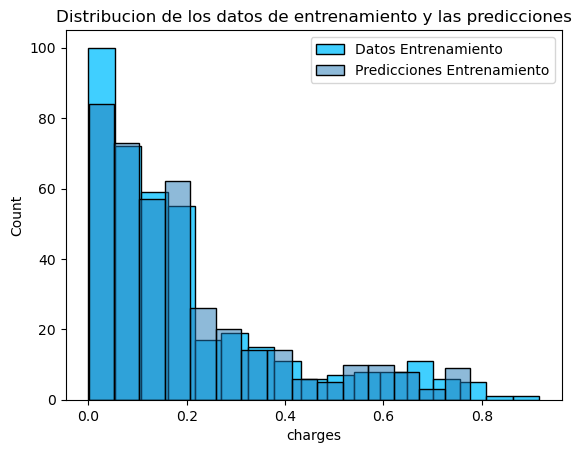

In [208]:
#Predicciones
pred_train_2 = modelo_2_final.predict(X_train)
pred_test_2 = modelo_2_final.predict(X_test)

pred_train_des_2 = pred_train_2 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_2 = pred_test_2 * (np.max(y) - np.min(y)) + np.min(y) 

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_2 = r2_score(y_train_des, pred_train_des_2)
rmse_train_2 = root_mean_squared_error(y_train_des, pred_train_des_2)
mae_train_2 = mean_absolute_error(y_train_des, pred_train_des_2)
mape_train_2 = mean_absolute_percentage_error(y_train_des, pred_train_des_2)
print(f'Las metricas de desempeño en entrenamiento para KNN son:\nR2: {r2_train_2:.4f}\nRMSE: {rmse_train_2:.4f}\nMAE: {mae_train_2:.4f}\nMAPE: {mape_train_2:.4f}')

#Visualizacion de las predicciones

sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_2, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


- tiene un ajuste de 91%.
- El mape no es buen indicador porque se tiene un cero en y da valores muy grandes.

Las metricas de desempeño en prueba para KNN son:
R2: 0.6955
RMSE: 0.1056
MAE: 0.0615
MAPE: 0.4924


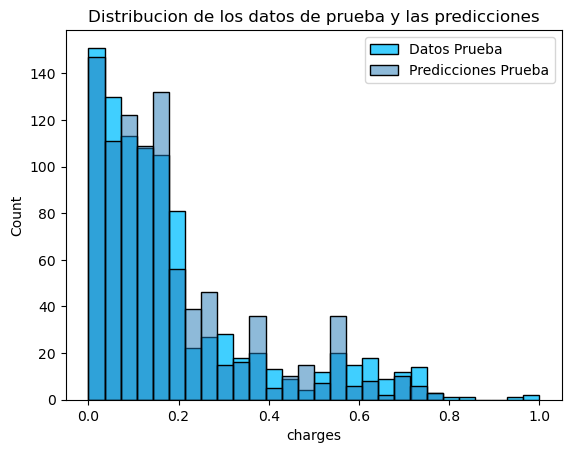

In [209]:
r2_test_2 = r2_score(y_test_des, pred_test_des_2)
rmse_test_2 = root_mean_squared_error(y_test_des, pred_test_des_2)
mae_test_2 = mean_absolute_error(y_test_des, pred_test_des_2)
mape_test_2 = mean_absolute_percentage_error(y_test_des, pred_test_des_2)

print(f'Las metricas de desempeño en prueba para KNN son:\nR2: {r2_test_2:.4f}\nRMSE: {rmse_test_2:.4f}\nMAE: {mae_test_2:.4f}\nMAPE: {mape_test_2:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_2, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()

- R2 la probabilidad de que el modelo se ajuste es de 69.55%.
- El mape es de 49.2% lo que indica que el modelo se quivoca en promedio un 49.2% en sus predicciones.

## **Maquina de soporte Vectorial**

In [210]:

modelo_3 = SVR()
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.001,0.01,0.1, 1, 10, 100, 1000], 
    'degree': [2,3,4,5]
}

reg_3 = GridSearchCV(estimator=modelo_3,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_mean_absolute_percentage_error',)
reg_3.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_3.cv_results_['params']), 
                        pd.DataFrame(reg_3.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)
# Al usar MAPE, el mejor es el valor más cercano a 0, pero como sklearn usa el negativo, el mejor es el más cercano a 0 por la izquierda (el menos negativo)

,C,degree,kernel,MAPE
32,0.1,2,linear,-5.731377e+09
36,0.1,3,linear,-5.731377e+09
44,0.1,5,linear,-5.731377e+09
40,0.1,4,linear,-5.731377e+09
77,10.0,5,poly,-2.621742e+10
...,...,...,...,...
87,100.0,3,sigmoid,-4.360355e+15
103,1000.0,3,sigmoid,-4.173758e+16
99,1000.0,2,sigmoid,-4.173758e+16
107,1000.0,4,sigmoid,-4.173758e+16


In [211]:
modelo_3_final = reg_3.best_estimator_
modelo_3_final

SVR(C=0.1, degree=2, kernel='linear')

Las metricas de desempeño en entrenamiento para SVM son:
R2: 0.7354
RMSE: 0.1015
MAE: 0.0764
MAPE: 253547964130.5365


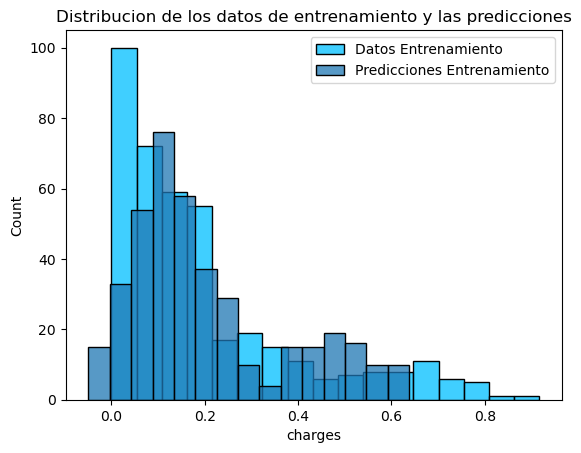

In [212]:
pred_train_3 = modelo_3_final.predict(X_train)
pred_test_3 = modelo_3_final.predict(X_test)

pred_train_des_3 = pred_train_3 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_3 = pred_test_3 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_3 = r2_score(y_train_des, pred_train_des_3)
rmse_train_3 = root_mean_squared_error(y_train_des, pred_train_des_3)
mae_train_3 = mean_absolute_error(y_train_des, pred_train_des_3)
mape_train_3 = mean_absolute_percentage_error(y_train_des, pred_train_des_3)

print(f'Las metricas de desempeño en entrenamiento para SVM son:\nR2: {r2_train_3:.4f}\nRMSE: {rmse_train_3:.4f}\nMAE: {mae_train_3:.4f}\nMAPE: {mape_train_3:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_3, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()

- tiene un ajuste de 73%.
- El mape no es buen indicador porque se tiene un cero en y da valores muy grandes.

Las metricas de desempeño en prueba para SVM son:
R2: 0.7362
RMSE: 0.0983
MAE: 0.0751
MAPE: 2.6007


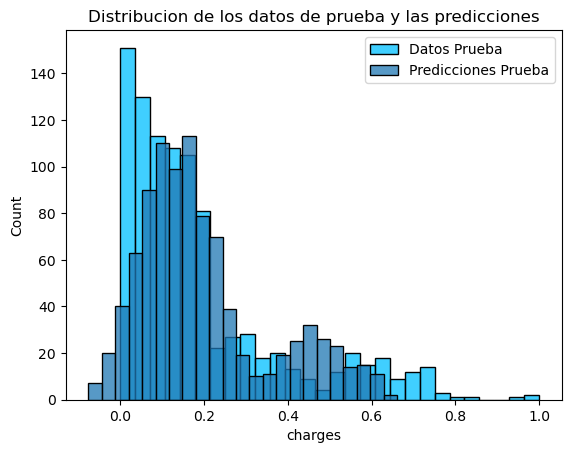

In [213]:
r2_test_3 = r2_score(y_test_des, pred_test_des_3)
rmse_test_3 = root_mean_squared_error(y_test_des, pred_test_des_3)
mae_test_3 = mean_absolute_error(y_test_des, pred_test_des_3)
mape_test_3 = mean_absolute_percentage_error(y_test_des, pred_test_des_3)
print(f'Las metricas de desempeño en prueba para SVM son:\nR2: {r2_test_3:.4f}\nRMSE: {rmse_test_3:.4f}\nMAE: {mae_test_3:.4f}\nMAPE: {mape_test_3:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_3, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()

- tiene un ajuste de 73%.
- El mape no es buen indicador porque se tiene un cero en y da valores muy grandes.

## **Arbol de Regresión**

In [214]:

modelo_4 = DecisionTreeRegressor(random_state=123)
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 7, 6, 3, 4, 10, 100, 1000, 20],
    'min_samples_split': [2,3,4],
    'max_leaf_nodes': [2,3,4, None]
}

reg_4 = GridSearchCV(estimator=modelo_4,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_mean_absolute_percentage_error',)
reg_4.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_4.cv_results_['params']), 
                        pd.DataFrame(reg_4.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)

# Al usar MAPE, el mejor es el valor más cercano a 0, pero como sklearn usa el negativo, el mejor es el más cercano a 0 por la izquierda (el menos negativo)

,criterion,max_depth,max_leaf_nodes,min_samples_split,MAPE
201,friedman_mse,10.0,NaN,2,-1.735497e+09
93,squared_error,100.0,NaN,2,-1.735497e+09
117,squared_error,20.0,NaN,2,-1.735497e+09
105,squared_error,1000.0,NaN,2,-1.735497e+09
9,squared_error,NaN,NaN,2,-1.735497e+09
...,...,...,...,...,...
433,poisson,10.0,2.0,3,-1.246471e+12
434,poisson,10.0,2.0,4,-1.246471e+12
444,poisson,100.0,2.0,2,-1.246471e+12
445,poisson,100.0,2.0,3,-1.246471e+12


In [215]:
modelo_4_final = reg_4.best_estimator_
modelo_4_final

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, random_state=123)

Las metricas de desempeño en entrenamiento para Arbol de Decision son:
R2: 0.9782
RMSE: 0.0291
MAE: 0.0082
MAPE: 0.1103


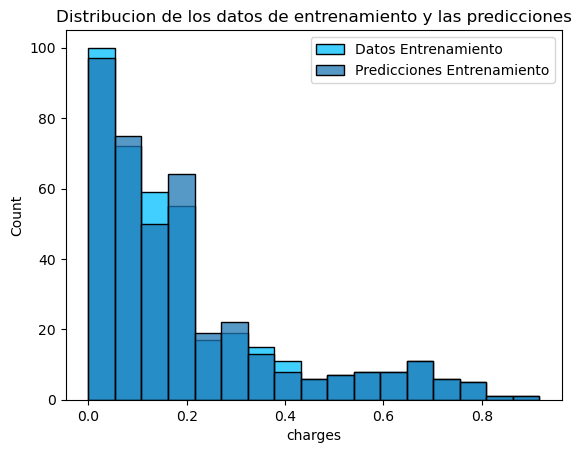

In [216]:
pred_train_4 = modelo_4_final.predict(X_train)
pred_test_4 = modelo_4_final.predict(X_test)

pred_train_des_4 = pred_train_4 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_4 = pred_test_4 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_4 = r2_score(y_train_des, pred_train_des_4)
rmse_train_4 = root_mean_squared_error(y_train_des, pred_train_des_4)
mae_train_4 = mean_absolute_error(y_train_des, pred_train_des_4)
mape_train_4 = mean_absolute_percentage_error(y_train_des, pred_train_des_4)

print(f'Las metricas de desempeño en entrenamiento para Arbol de Decision son:\nR2: {r2_train_4:.4f}\nRMSE: {rmse_train_4:.4f}\nMAE: {mae_train_4:.4f}\nMAPE: {mape_train_4:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_4, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desempeño en prueba para Arbol de Decision son:
R2: 0.7447
RMSE: 0.0967
MAE: 0.0488
MAPE: 0.5681


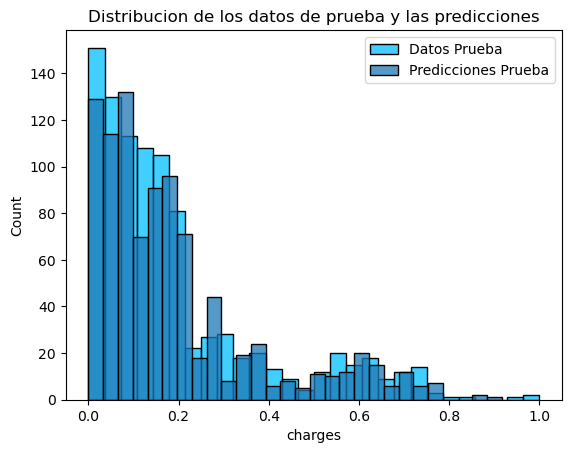

In [217]:
r2_test_4 = r2_score(y_test_des, pred_test_des_4)
rmse_test_4 = root_mean_squared_error(y_test_des, pred_test_des_4)
mae_test_4 = mean_absolute_error(y_test_des, pred_test_des_4)
mape_test_4 = mean_absolute_percentage_error(y_test_des, pred_test_des_4)
print(f'Las metricas de desempeño en prueba para Arbol de Decision son:\nR2: {r2_test_4:.4f}\nRMSE: {rmse_test_4:.4f}\nMAE: {mae_test_4:.4f}\nMAPE: {mape_test_4:.4f}')

#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_4, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Bosque aleatorio**

In [218]:

modelo_5 = RandomForestRegressor(random_state=123)
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 6, 3, 4, 10, 100],
    'max_leaf_nodes': [2,3,4, None],
    'n_estimators':[100,200,500]
    }


reg_5 = GridSearchCV(estimator=modelo_5,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_mean_absolute_percentage_error',)
reg_5.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_5.cv_results_['params']), 
                        pd.DataFrame(reg_5.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)


,criterion,max_depth,max_leaf_nodes,n_estimators,MAPE
333,poisson,100.0,NaN,100,-3.907394e+10
261,poisson,NaN,NaN,100,-3.907394e+10
321,poisson,10.0,NaN,100,-3.993508e+10
334,poisson,100.0,NaN,200,-4.135936e+10
262,poisson,NaN,NaN,200,-4.135936e+10
...,...,...,...,...,...
49,squared_error,4.0,2.0,200,-1.244059e+12
289,poisson,3.0,2.0,200,-1.244059e+12
277,poisson,6.0,2.0,200,-1.244059e+12
265,poisson,5.0,2.0,200,-1.244059e+12


In [219]:
modelo_5_final = reg_5.best_estimator_
modelo_5_final

RandomForestRegressor(criterion='poisson', random_state=123)

Las metricas de desempeño en entrenamiento para Bosque aleatorio son:
R2: 0.97661
RMSE: 0.03018
MAE: 0.01548
MAPE: 25048259888.66187


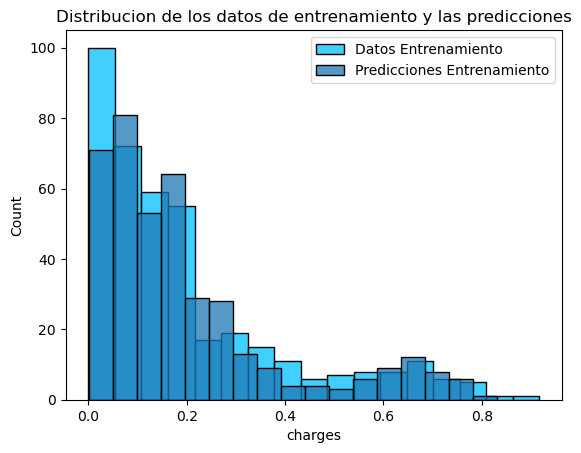

In [220]:
pred_train_5 = modelo_5_final.predict(X_train)
pred_test_5 = modelo_5_final.predict(X_test)

pred_train_des_5 = pred_train_5 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_5 = pred_test_5 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_5 = r2_score(y_train_des, pred_train_des_5)
rmse_train_5 = root_mean_squared_error(y_train_des, pred_train_des_5)
mae_train_5 = mean_absolute_error(y_train_des, pred_train_des_5)
mape_train_5 = mean_absolute_percentage_error(y_train_des, pred_train_des_5)

print(f'Las metricas de desempeño en entrenamiento para Bosque aleatorio son:\nR2: {r2_train_5:.5f}\nRMSE: {rmse_train_5:.5f}\nMAE: {mae_train_5:.5f}\nMAPE: {mape_train_5:.5f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_5, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desepeños de prueba para bosque aleatorio son:
R2: 0.84377
RMSE: 0.07566
MAE: 0.04193
MAPE: 0.48157


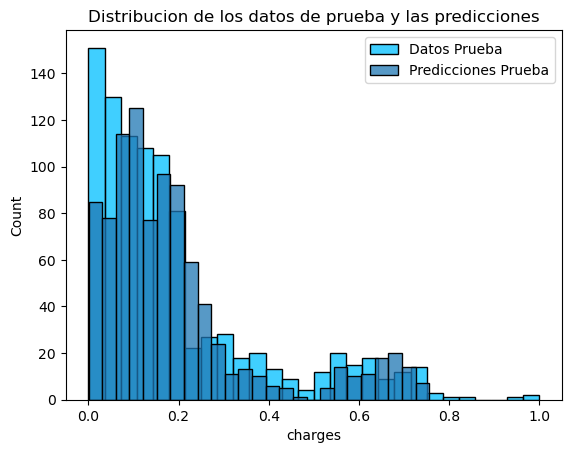

In [221]:
r2_test_5 = r2_score(y_test_des, pred_test_des_5)
rmse_test_5 = root_mean_squared_error(y_test_des, pred_test_des_5)
mae_test_5 = mean_absolute_error(y_test_des, pred_test_des_5)
mape_test_5 = mean_absolute_percentage_error(y_test_des, pred_test_des_5)
print(f'Las metricas de desepeños de prueba para bosque aleatorio son:\nR2: {r2_test_5:.5f}\nRMSE: {rmse_test_5:.5f}\nMAE: {mae_test_5:.5f}\nMAPE: {mape_test_5:.5f}')

#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_5, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Adaptative Boosting**

In [222]:
modelo_6 = AdaBoostRegressor()

param_grid = {'n_estimators': [100,200,400,600], 'loss':['linar', 'square', 'exponetial'],
              'learning_rate':[0.001, 0.01, 0.1,1,10]}

reg_6 = GridSearchCV(estimator=modelo_6, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error')

reg_6.fit(X_train, y_train)

validation = pd.concat([pd.DataFrame(reg_6.cv_results_['params']), 
                        pd.DataFrame(reg_6.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)


,learning_rate,loss,n_estimators,MAPE
4,0.001,square,100,-4.033655e+11
5,0.001,square,200,-4.195249e+11
6,0.001,square,400,-4.408761e+11
7,0.001,square,600,-4.558557e+11
16,0.010,square,100,-4.792705e+11
17,0.010,square,200,-5.440191e+11
18,0.010,square,400,-5.845853e+11
31,0.100,square,600,-6.978305e+11
30,0.100,square,400,-7.420902e+11
29,0.100,square,200,-7.783669e+11


In [223]:
modelo_6_final = reg_6.best_estimator_
modelo_6_final

AdaBoostRegressor(learning_rate=0.001, loss='square', n_estimators=100)

Las metricas de desempeño en entrenamiento para AdaBoost son:
R2: 0.8681
RMSE: 0.0717
MAE: 0.0423
MAPE: 421750346395.8023


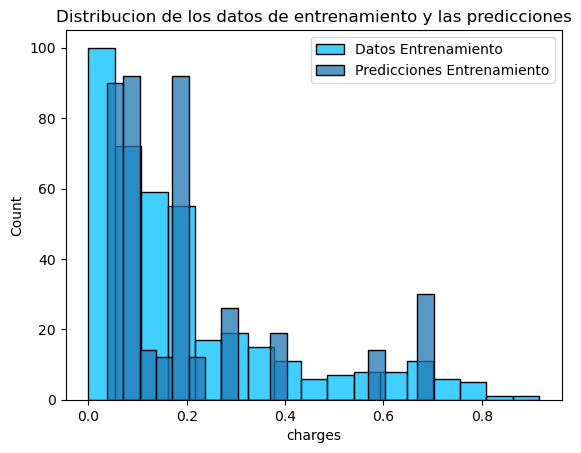

In [224]:
pred_train_6 = modelo_6_final.predict(X_train)
pred_test_6 = modelo_6_final.predict(X_test)

pred_train_des_6 = pred_train_6 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_6 = pred_test_6 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_6 = r2_score(y_train_des, pred_train_des_6)
rmse_train_6 = root_mean_squared_error(y_train_des, pred_train_des_6)
mae_train_6 = mean_absolute_error(y_train_des, pred_train_des_6)
mape_train_6 = mean_absolute_percentage_error(y_train_des, pred_train_des_6)

print(f'Las metricas de desempeño en entrenamiento para AdaBoost son:\nR2: {r2_train_6:.4f}\nRMSE: {rmse_train_6:.4f}\nMAE: {mae_train_6:.4f}\nMAPE: {mape_train_6:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_6, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desempeño en prueba para AdaBoost son:
R2: 0.8511
RMSE: 0.0739
MAE: 0.0442
MAPE: 1.3689


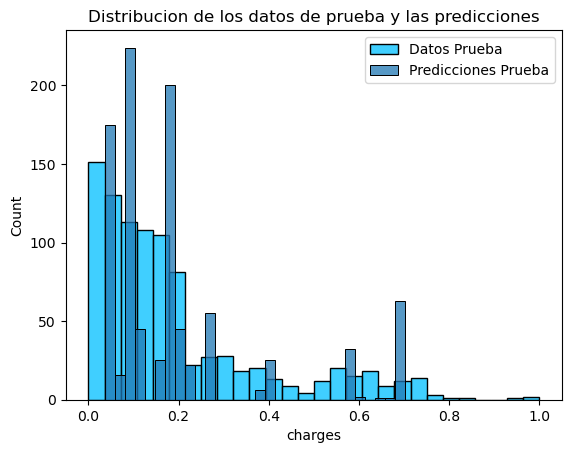

In [225]:
r2_test_6 = r2_score(y_test_des, pred_test_des_6)
rmse_test_6 = root_mean_squared_error(y_test_des, pred_test_des_6)
mae_test_6 = mean_absolute_error(y_test_des, pred_test_des_6)
mape_test_6 = mean_absolute_percentage_error(y_test_des, pred_test_des_6)
print(f'Las metricas de desempeño en prueba para AdaBoost son:\nR2: {r2_test_6:.4f}\nRMSE: {rmse_test_6:.4f}\nMAE: {mae_test_6:.4f}\nMAPE: {mape_test_6:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_6, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Gradient Boosting**

In [226]:

modelo_7 = GradientBoostingRegressor()

param_grid ={'loss':['squared_error', 'absolute_error'],
             'n_estimators':[100,200,400,500,1000],
             'criterion':['friendman_mse', 'squared_error']}


reg_7 = GridSearchCV(estimator=modelo_7, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error',)

reg_7.fit(X_train, y_train)

validation = pd.concat([pd.DataFrame(reg_7.cv_results_['params']), 
                        pd.DataFrame(reg_7.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)

,criterion,loss,n_estimators,MAPE
19,squared_error,absolute_error,1000,-4.794895e+10
15,squared_error,absolute_error,100,-6.009610e+10
16,squared_error,absolute_error,200,-7.991640e+10
18,squared_error,absolute_error,500,-8.554361e+10
17,squared_error,absolute_error,400,-1.270329e+11
10,squared_error,squared_error,100,-7.342267e+11
12,squared_error,squared_error,400,-1.295220e+12
13,squared_error,squared_error,500,-1.318236e+12
11,squared_error,squared_error,200,-1.341329e+12
14,squared_error,squared_error,1000,-1.556263e+12


In [227]:
modelo_7_final = reg_7.best_estimator_
modelo_7_final

GradientBoostingRegressor(criterion='squared_error', loss='absolute_error',
                          n_estimators=1000)

Las metricas de desempeño en entrenamiento para Gradient Boosting son:
R2: 0.8634
RMSE: 0.0729
MAE: 0.0259
MAPE: 4732790388.1649


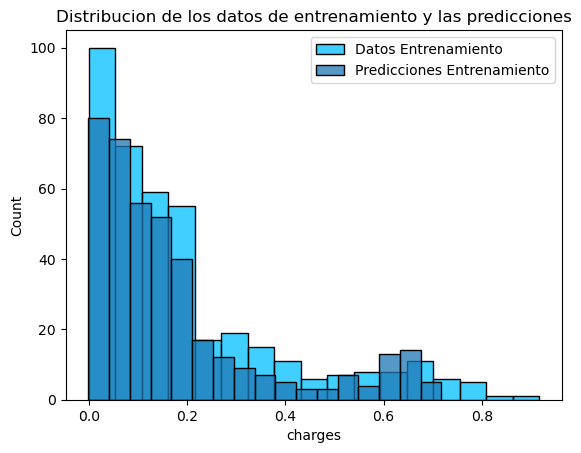

In [228]:
pred_train_7 = modelo_7_final.predict(X_train)
pred_test_7 = modelo_7_final.predict(X_test)

pred_train_des_7 = pred_train_7 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_7 = pred_test_7 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_7 = r2_score(y_train_des, pred_train_des_7)
rmse_train_7 = root_mean_squared_error(y_train_des, pred_train_des_7)
mae_train_7 = mean_absolute_error(y_train_des, pred_train_des_7)
mape_train_7 = mean_absolute_percentage_error(y_train_des, pred_train_des_7)

print(f'Las metricas de desempeño en entrenamiento para Gradient Boosting son:\nR2: {r2_train_7:.4f}\nRMSE: {rmse_train_7:.4f}\nMAE: {mae_train_7:.4f}\nMAPE: {mape_train_7:.4f}')
#Visualizacion de las predicciones

sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_7, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desempeño en prueba para Gradient Boosting son:
R2: 0.8290
RMSE: 0.0792
MAE: 0.0337
MAPE: 0.2078


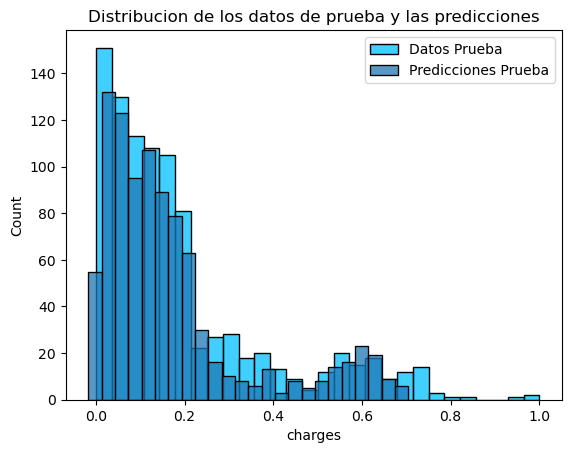

In [229]:
r2_test_7 = r2_score(y_test_des, pred_test_des_7)
rmse_test_7 = root_mean_squared_error(y_test_des, pred_test_des_7)
mae_test_7 = mean_absolute_error(y_test_des, pred_test_des_7)
mape_test_7 = mean_absolute_percentage_error(y_test_des, pred_test_des_7)

print(f'Las metricas de desempeño en prueba para Gradient Boosting son:\nR2: {r2_test_7:.4f}\nRMSE: {rmse_test_7:.4f}\nMAE: {mae_test_7:.4f}\nMAPE: {mape_test_7:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_7, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Perceptron Multicapa**

In [230]:

modelo_8 = MLPRegressor(random_state=123)

param_grid = {
    'hidden_layer_sizes': [(10,), (10,10), (10,10,10), (20, 10)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate_init': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [200, 300, 400]
}

reg_8 =GridSearchCV(estimator=modelo_8,
                          param_grid=param_grid,   
                            cv=3,
                            scoring='neg_mean_absolute_percentage_error',
                            n_jobs=-1)
reg_8.fit(X_train, y_train)

validation = pd.concat([pd.DataFrame(reg_8.cv_results_['params']), 
                        pd.DataFrame(reg_8.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)

,activation,hidden_layer_sizes,learning_rate_init,max_iter,solver,MAPE
519,logistic,"(20, 10)",0.1,400,adam,-5.292009e+09
513,logistic,"(20, 10)",0.1,200,adam,-5.292009e+09
516,logistic,"(20, 10)",0.1,300,adam,-5.292009e+09
378,logistic,"(10,)",0.1,200,adam,-9.507237e+09
381,logistic,"(10,)",0.1,300,adam,-9.507237e+09
...,...,...,...,...,...,...
268,tanh,"(10, 10)",10.0,400,sgd,-4.710403e+66
265,tanh,"(10, 10)",10.0,300,sgd,-4.710403e+66
355,tanh,"(20, 10)",10.0,300,sgd,-4.666915e+67
358,tanh,"(20, 10)",10.0,400,sgd,-4.666915e+67


In [231]:
modelo_8_final = reg_8.best_estimator_
modelo_8_final

MLPRegressor(activation='logistic', hidden_layer_sizes=(20, 10),
             learning_rate_init=0.1, random_state=123)

Las metricas de desempeño en entrenamiento para Perceptron Multicapa son:
R2: 0.5488
RMSE: 0.1326
MAE: 0.0954
MAPE: 1112049513971.1931


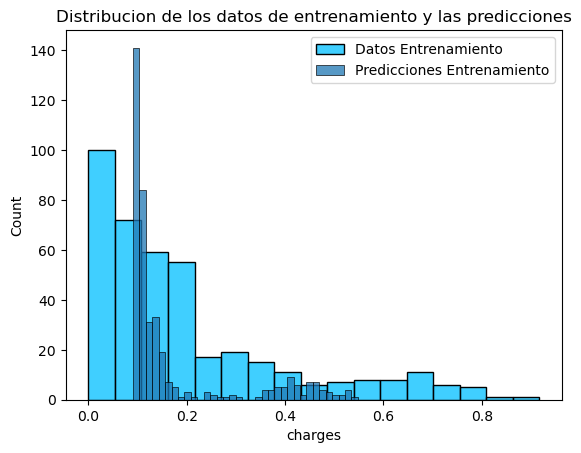

In [232]:
pred_train_8 = modelo_8_final.predict(X_train)
pred_test_8 = modelo_8_final.predict(X_test)

pred_train_des_8 = pred_train_8 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_8 = pred_test_8 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_8 = r2_score(y_train_des, pred_train_des_8)
rmse_train_8 = root_mean_squared_error(y_train_des, pred_train_des_8)
mae_train_8 = mean_absolute_error(y_train_des, pred_train_des_8)
mape_train_8 = mean_absolute_percentage_error(y_train_des, pred_train_des_8)

print(f'Las metricas de desempeño en entrenamiento para Perceptron Multicapa son:\nR2: {r2_train_8:.4f}\nRMSE: {rmse_train_8:.4f}\nMAE: {mae_train_8:.4f}\nMAPE: {mape_train_8:.4f}')
#Visualizacion de las predicciones

sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_8, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desempeño en prueba para Perceptron Multicapa son:
R2: 0.5199
RMSE: 0.1326
MAE: 0.0925
MAPE: 3.5774


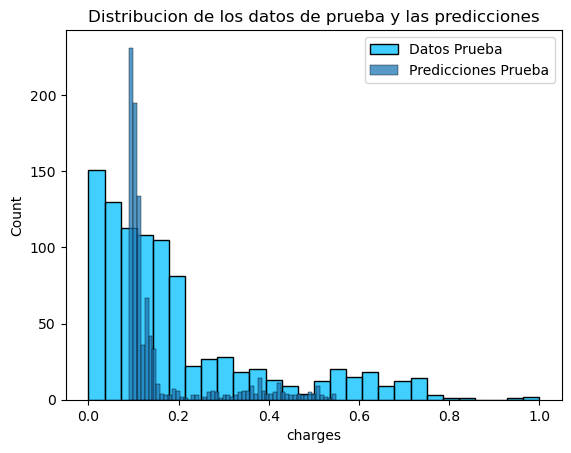

In [233]:
r2_test_8 = r2_score(y_test_des, pred_test_des_8)
rmse_test_8 = root_mean_squared_error(y_test_des, pred_test_des_8)
mae_test_8 = mean_absolute_error(y_test_des, pred_test_des_8)
mape_test_8 = mean_absolute_percentage_error(y_test_des, pred_test_des_8)

print(f'Las metricas de desempeño en prueba para Perceptron Multicapa son:\nR2: {r2_test_8:.4f}\nRMSE: {rmse_test_8:.4f}\nMAE: {mae_test_8:.4f}\nMAPE: {mape_test_8:.4f}')
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_8, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Huber Regressor**

El Huber Regressor es un modelo de regresión robusto frente a valores atípicos (outliers).  
Su funcionamiento se basa en la **función de pérdida de Huber**, que combina lo mejor de la regresión lineal clásica y la regresión robusta:

- Para errores pequeños (residuales cercanos a 0) utiliza el **error cuadrático** (como la regresión lineal).  
- Para errores grandes (posibles outliers) utiliza el **error absoluto**, reduciendo el impacto de estos en el modelo.

La transición entre ambas zonas está controlada por el hiperparámetro `epsilon (ε)`:
- Valores pequeños → modelo más sensible a outliers.  
- Valores grandes → modelo se comporta más como una regresión lineal clásica.  

Otros hiperparámetros importantes:
- `alpha`: controla la regularización L2.  
- `epsilon`: umbral de corte entre error cuadrático y absoluto.  
- `max_iter`: número máximo de iteraciones.  


In [234]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV




In [235]:
#Hubber

modelo_9 = HuberRegressor()
param_grid_9 = {
    "alpha": [0.001, 0.01, 0.1, 1, 10 , 100, 1000],      # regularización L2
    "epsilon": [1.1, 1.35, 1.5, 1.75, 2.0], # umbral Huber (controla sensibilidad a outliers)
    "max_iter": [100, 500, 1000]
}


reg_9 = GridSearchCV(
    estimator=modelo_9,
    param_grid=param_grid_9,
    scoring="neg_mean_absolute_percentage_error",  # maximize neg MAPE -> minimize MAPE
    cv=5,
    n_jobs=-1,
    verbose=1
)

reg_9.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_9.cv_results_['params']), 
                        pd.DataFrame(reg_6.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


,alpha,epsilon,max_iter,MAPE
4,0.001,1.35,500,-4.033655e+11
5,0.001,1.35,1000,-4.195249e+11
6,0.001,1.50,100,-4.408761e+11
7,0.001,1.50,500,-4.558557e+11
16,0.010,1.10,500,-4.792705e+11
...,...,...,...,...
100,1000.000,1.75,500,NaN
101,1000.000,1.75,1000,NaN
102,1000.000,2.00,100,NaN
103,1000.000,2.00,500,NaN


In [236]:
modelo_9_final = reg_9.best_estimator_
modelo_9_final

HuberRegressor(alpha=100, epsilon=1.75)

Las metricas de desempeño en entrenamiento para Perceptron Multicapa son:
R2: 0.6564
RMSE: 0.1157
MAE: 0.0621
MAPE: 35652068577.9803


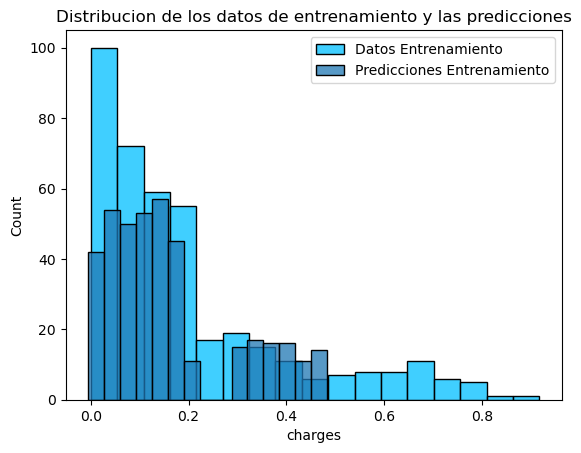

In [237]:
pred_train_9 = modelo_9_final.predict(X_train)
pred_test_9 = modelo_9_final.predict(X_test)

pred_train_des_9 = pred_train_9 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_9 = pred_test_9 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_9 = r2_score(y_train_des, pred_train_des_9)
rmse_train_9 = root_mean_squared_error(y_train_des, pred_train_des_9)
mae_train_9 = mean_absolute_error(y_train_des, pred_train_des_9)
mape_train_9 = mean_absolute_percentage_error(y_train_des, pred_train_des_9)

print(f'Las metricas de desempeño en entrenamiento para Perceptron Multicapa son:\nR2: {r2_train_9:.4f}\nRMSE: {rmse_train_9:.4f}\nMAE: {mae_train_9:.4f}\nMAPE: {mape_train_9:.4f}')
#Visualizacion de las predicciones

sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_9, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()

Las metricas de desempeño en prueba para Perceptron Multicapa son:
R2: 0.6674
RMSE: 0.1104
MAE: 0.0601
MAPE: 0.7483


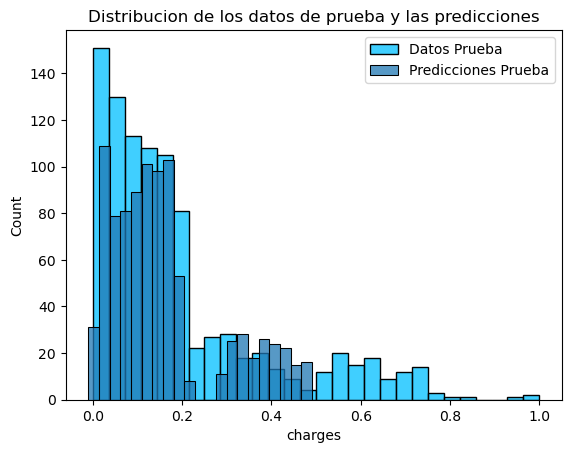

In [238]:
r2_test_9 = r2_score(y_test_des, pred_test_des_9)
rmse_test_9 = root_mean_squared_error(y_test_des, pred_test_des_9)
mae_test_9 = mean_absolute_error(y_test_des, pred_test_des_9)
mape_test_9 = mean_absolute_percentage_error(y_test_des, pred_test_des_9)

print(f'Las metricas de desempeño en prueba para Perceptron Multicapa son:\nR2: {r2_test_9:.4f}\nRMSE: {rmse_test_9:.4f}\nMAE: {mae_test_9:.4f}\nMAPE: {mape_test_9:.4f}')
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_9, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()

# **Construcción del Pipeline del Modelo**

- Identificar las variables a ser ignoradas - No hay pero se deja en el codigo
- Implementar los mecanismos de imputación de datos nulos
- Implementar las transformaciones de datos (Escalamientos y Codificaciones)
- Implementar el modelo elegido

In [239]:
#los datos estaban muy bien - en la prep datos al cambiarlos el pipeline lo que hace - procesamiento de los datos ,  
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [240]:
data = pd.read_csv('datos_caso_3.csv')
target = 'charges'
X = data.drop(columns = [target])
y = data[[target]]

In [241]:
#Identificar las variables numéricas y categóricas, además las variables a ignorar
all_num = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
all_cat = X.select_dtypes(include = ['object']).columns.to_list()
#ignored = ['date', 'quarter'] 
num_features = [c for c in all_num if c not in ignored]
cat_features = [c for c in all_cat if c not in ignored]

In [242]:
#Crear los pipelines de imputación y transformación
###Imputador por vecindad a las variables numéricas y un escalamiento MinMax
###Imputador simple por moda a las variables categóricas y una codificación OneHot
num_pipe = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 10)), ('scaler', MinMaxScaler())]) #se hace la escalada 
cat_pipe = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')), ('encoder', OneHotEncoder())]) # con onehotenc 
#el pipeline lo hace solo 
# podriamos quitar la parte del imputer pero es bueno por si al momento de hacer el modelo igual se deja 


In [243]:
num_pipe

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10)),
                ('scaler', MinMaxScaler())])

In [244]:
cat_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder())])

In [245]:
preprocessor = ColumnTransformer(transformers = [('num', num_pipe, num_features), ('cat', cat_pipe, cat_features)], remainder = 'drop') #se dropea lo que no quedo en lo s otros pipe  
#ejecuta el pipe


In [246]:
#GradientBoostingRegressor(criterion='squared_error', loss='absolute_error',
#aquí sacamos los hiperparametros de la que nos tiro el mejor mape 

model = GradientBoostingRegressor(
  criterion='squared_error',
  n_estimators=1000,
  loss= 'absolute_error'
)

pipe_model = Pipeline(
  steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ]
)
pipe_model
#ahi imprimio el step de ese pipe model 


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model',
                 GradientBoostingRegressor(criterion='squared_error',
                                           loss='absolute_error',
                                           n_estimators=1000))])

In [247]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, train_size=0.7
)

pipe_model.fit(X_train, y_train)
#ya se le hizo el fit al modelo 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model',
                 GradientBoostingRegressor(criterion='squared_error',
                                           loss='absolute_error',
                                           n_estimators=1000))])

In [248]:
y_pred = pipe_model.predict(X_test)
y_pred
#predijo que es lo que dió

array([ 3892.18011491, 12467.51545123, 13479.0541391 ,  6972.82551723,
        4952.70347072, 13151.4052306 , 12544.71406635,  4294.21792435,
        6209.29467186, 13180.92907515, 12923.02297115,  7211.82234826,
        9962.67681808,  2217.34615128, 13527.21349001,  2948.25979079,
       29800.49478521,  1627.11320746,  2964.70188262, 43636.44768366,
        6580.67973928,  4201.90842587,  9825.12427634,  9534.36631791,
        6283.44211143, 41201.83643689,  1659.27625391, 46020.59076348,
        4103.30594451, 23810.58040223, 35194.631694  , 13852.71715306,
        9422.75415562,  2215.41066155,  1627.11320746,  2721.48179315,
        7831.17612357,  1631.79416524,  5025.36056347,  9892.3855231 ,
        1242.47422433,  8429.80686839,  3705.97053142,  4695.3428158 ,
        1627.11320746,  4219.67291715, 25229.10464468,  2981.6062516 ,
        8517.37704861,  7559.82562791,  4994.19173229,  6324.08343437,
        1791.65451115,  1188.72939442,  3933.30704006, 10711.2163878 ,
      

In [249]:
def mostrar_metricas(y_train_des, pred_train_des, y_test_des, pred_test_des, nombre_modelo="Modelo"):
    # Entrenamiento
    r2_train = r2_score(y_train_des, pred_train_des)
    rmse_train = root_mean_squared_error(y_train_des, pred_train_des)
    mae_train = mean_absolute_error(y_train_des, pred_train_des)
    mape_train = mean_absolute_percentage_error(y_train_des, pred_train_des)



    print(f"Las métricas de desempeño en entrenamiento para {nombre_modelo} son:")
    print(f"R2: {r2_train}")
    print(f"RMSE: {rmse_train}")
    print(f"MAE: {mae_train}")
    print(f"MAPE: {mape_train}")


    sb.histplot(data=y_train_des, label='Datos de entrenamiento')
    sb.histplot(pred_train_des, label='Predicciones de entrenamiento')
    plt.legend()
    plt.show()

    # Test
    r2_test = r2_score(y_test_des, pred_test_des)
    rmse_test = root_mean_squared_error(y_test_des, pred_test_des)
    mae_test = mean_absolute_error(y_test_des, pred_test_des)
    mape_test = mean_absolute_percentage_error(y_test_des, pred_test_des)



    print(f"Las métricas de desempeño en test para {nombre_modelo} son:")
    print(f"R2: {r2_test}")
    print(f"RMSE: {rmse_test}")
    print(f"MAE: {mae_test}")
    print(f"MAPE: {mape_test}")

    sb.histplot(data=y_test_des, label='Datos de test')
    sb.histplot(pred_test_des, label='Predicciones de test')
    plt.legend()
    plt.show()

Las métricas de desempeño en entrenamiento para Gradient Boosting son:
R2: 0.8398082105230912
RMSE: 296568568.9045357
MAE: 104814007.35712695
MAPE: 0.0764614251627102


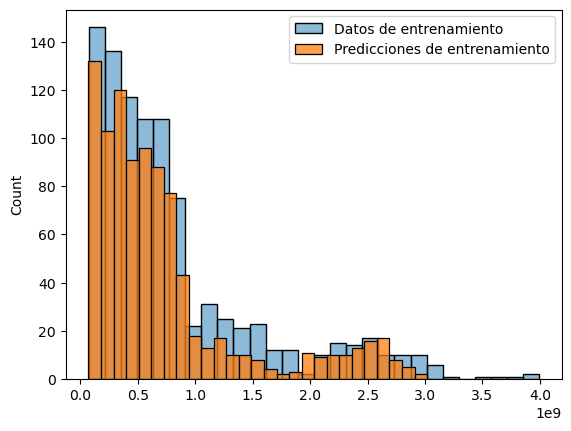

Las métricas de desempeño en test para Gradient Boosting son:
R2: 0.8298821929823148
RMSE: 328300146.22395957
MAE: 136893182.9743172
MAPE: 0.09800039966836688


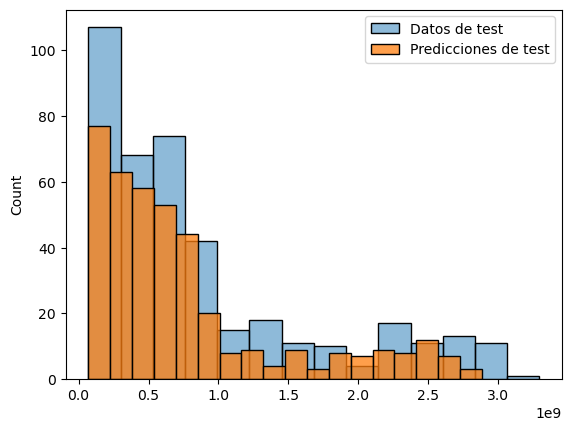

In [250]:
pred_train_7, pred_test_7, y_train_des, y_test_des = predecir_y_desescalar(pipe_model, X_train, X_test, y_train, y_test, y)
mostrar_metricas(y_train_des, pred_train_7, y_test_des, pred_test_7, nombre_modelo="Gradient Boosting")

In [251]:
import joblib #job lib es para exportar modelos 
joblib.dump(pipe_model, 'modelo_regresion_caso_3.pkl')

['modelo_regresion_caso_3.pkl']

In [252]:
modelo_guardado = joblib.load('modelo_regresion_caso_3.pkl')
modelo_guardado.predict(X_test)
#cargar el modelo 


array([ 3892.18011491, 12467.51545123, 13479.0541391 ,  6972.82551723,
        4952.70347072, 13151.4052306 , 12544.71406635,  4294.21792435,
        6209.29467186, 13180.92907515, 12923.02297115,  7211.82234826,
        9962.67681808,  2217.34615128, 13527.21349001,  2948.25979079,
       29800.49478521,  1627.11320746,  2964.70188262, 43636.44768366,
        6580.67973928,  4201.90842587,  9825.12427634,  9534.36631791,
        6283.44211143, 41201.83643689,  1659.27625391, 46020.59076348,
        4103.30594451, 23810.58040223, 35194.631694  , 13852.71715306,
        9422.75415562,  2215.41066155,  1627.11320746,  2721.48179315,
        7831.17612357,  1631.79416524,  5025.36056347,  9892.3855231 ,
        1242.47422433,  8429.80686839,  3705.97053142,  4695.3428158 ,
        1627.11320746,  4219.67291715, 25229.10464468,  2981.6062516 ,
        8517.37704861,  7559.82562791,  4994.19173229,  6324.08343437,
        1791.65451115,  1188.72939442,  3933.30704006, 10711.2163878 ,
      

Las métricas de desempeño en entrenamiento para Gradient Boosting son:
R2: 0.8398082105230912
RMSE: 296568568.9045357
MAE: 104814007.35712695
MAPE: 0.0764614251627102


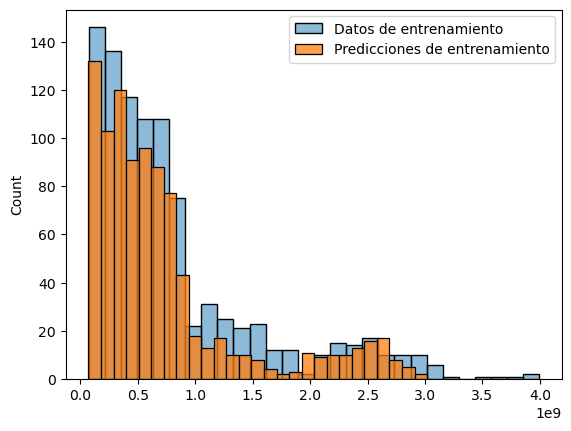

Las métricas de desempeño en test para Gradient Boosting son:
R2: 0.8298821929823148
RMSE: 328300146.22395957
MAE: 136893182.9743172
MAPE: 0.09800039966836688


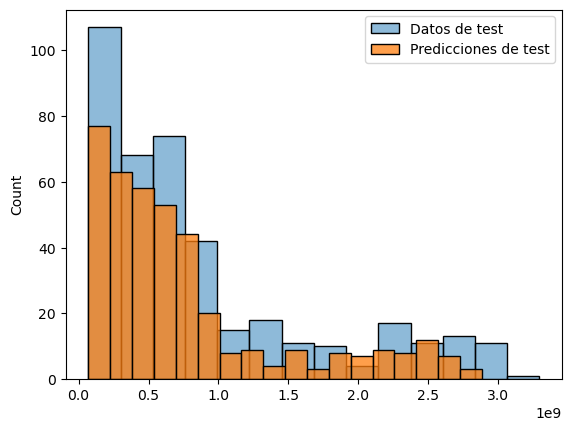

In [253]:
pred_train_7, pred_test_7, y_train_des, y_test_des = predecir_y_desescalar(modelo_guardado, X_train, X_test, y_train, y_test, y)
mostrar_metricas(y_train_des, pred_train_7, y_test_des, pred_test_7, nombre_modelo="Gradient Boosting")